In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (14,7)

In [2]:
def read_load(fn):
    df = pd.read_csv(fn)
    df['Date'] = pd.to_datetime(df['Date'])
    df['ds'] = pd.to_datetime(df.apply(
        lambda row: f"{row['Date'].strftime('%Y-%m-%d')}T{str(row['Hour']-1)}:00:00",
        axis=1
    ))
    df = df[['ds', 'Load']]
    
    # Make sure there are no skipped timestamps
    df.set_index('ds', inplace=True)
    
    # remove duplicated ds from time daylight savings
    df = df[~df.index.duplicated()]
    df.asfreq('H')
    # df.reset_index(inplace=True)
    
    return df

def read_weather(fn):
    df = pd.read_csv(fn)
    df['Date'] = pd.to_datetime(df['Date'])
    df['ds'] = pd.to_datetime(df.apply(
        lambda row: f"{row['Date'].strftime('%Y-%m-%d')}T{str(row['Hour']-1)}:00:00",
        axis=1
    ))
    
    df = df[['ds', 'Station ID', 'Temperature']]
    df.rename(columns={'Station ID': 'station_id', 'Temperature': 'temperature'}, inplace=True)
    
    df = df[~df.duplicated(subset=['ds', 'station_id'])]
    
    return df

load = read_load("./data/load_hist_data.csv")
weather = read_weather("./data/weather_data.csv")

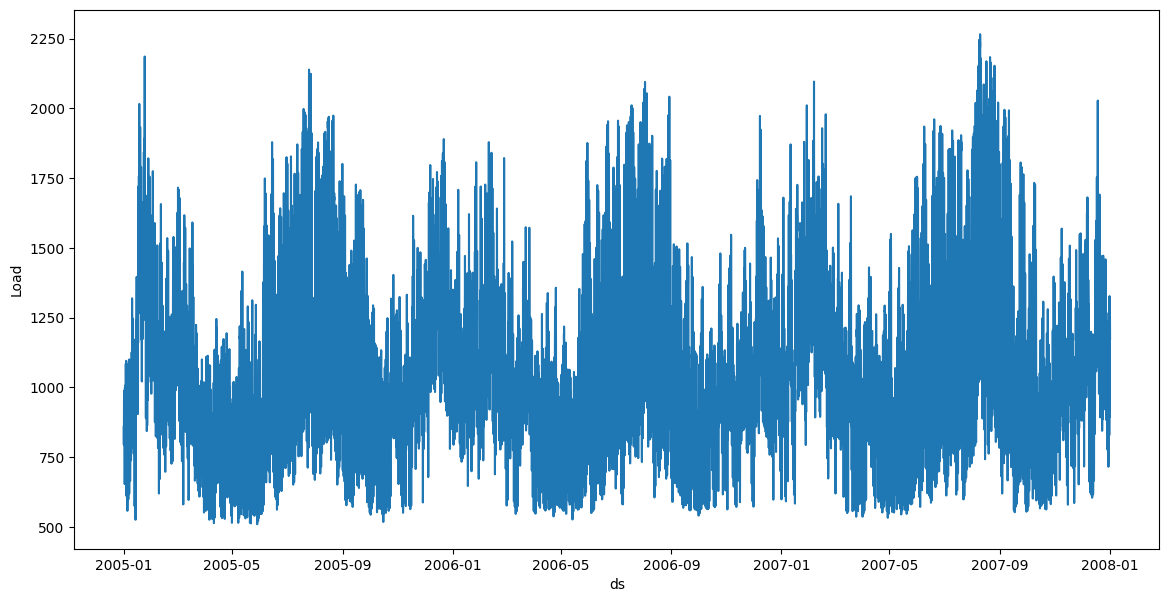

In [3]:
g=sns.lineplot(load, x='ds', y='Load')

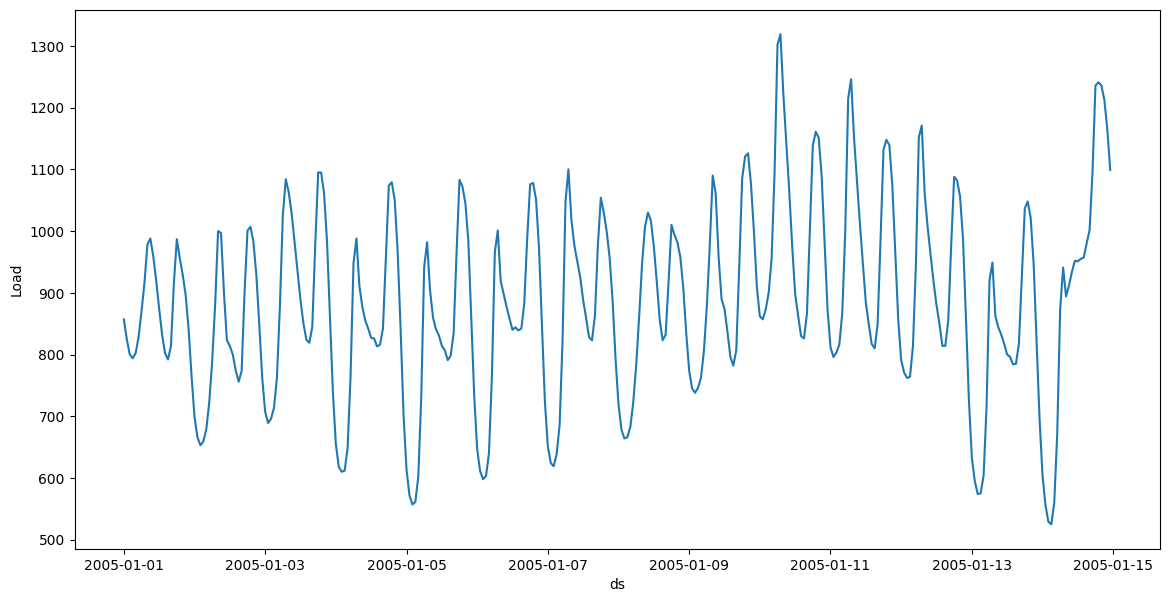

In [4]:
g=sns.lineplot(load.head(24*14), x='ds', y='Load')

<Axes: xlabel='ds', ylabel='temperature'>

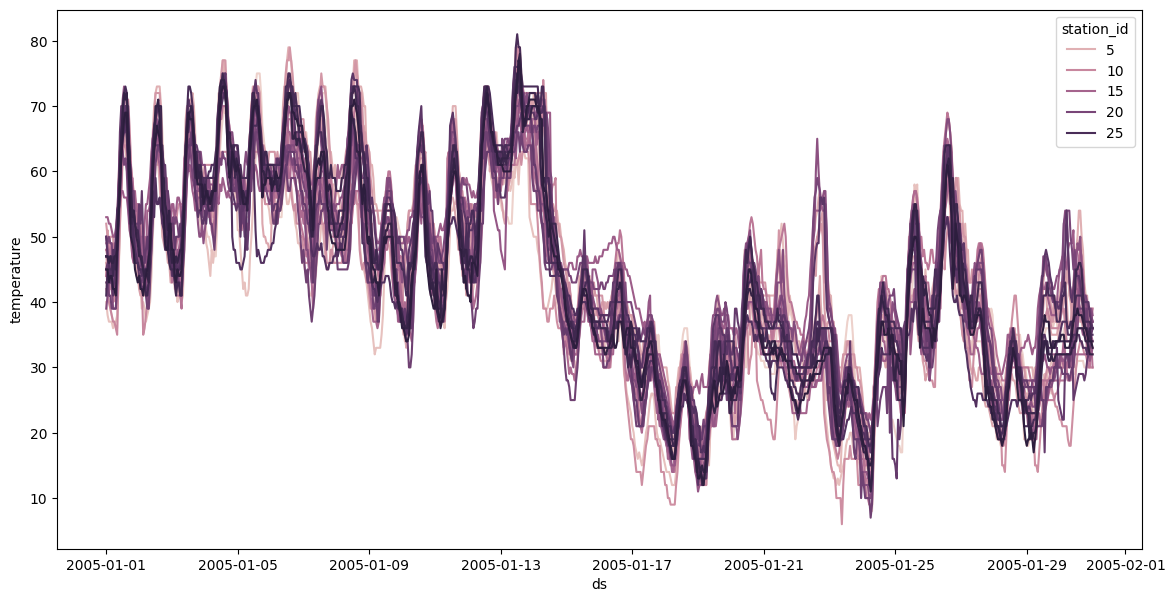

In [6]:
sns.lineplot(data=weather[weather.ds <= '2005-01-31'], x='ds', y='temperature', hue='station_id')

In [ ]:
def featurize_weather(weather):
    weather_features = weather.groupby(['ds']).agg(
        min_station_temp = ('temperature', np.min),
        max_station_temp = ('temperature', np.max),
        mean_station_temp = ('temperature', np.mean)
    ).reset_index()
    
    return weather_features

/tmp/ipykernel_22490/2706878351.py:1: FutureWarning: The provided callable <function min at 0x7fed181f0720> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  weather_features = weather.groupby(['ds']).agg(
/tmp/ipykernel_22490/2706878351.py:1: FutureWarning: The provided callable <function max at 0x7fed181f05e0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  weather_features = weather.groupby(['ds']).agg(
/tmp/ipykernel_22490/2706878351.py:1: FutureWarning: The provided callable <function mean at 0x7fed181f0fe0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  weather_features = weather.groupby(['ds']).agg(


Text(0.5, 1.0, 'Weather Features')

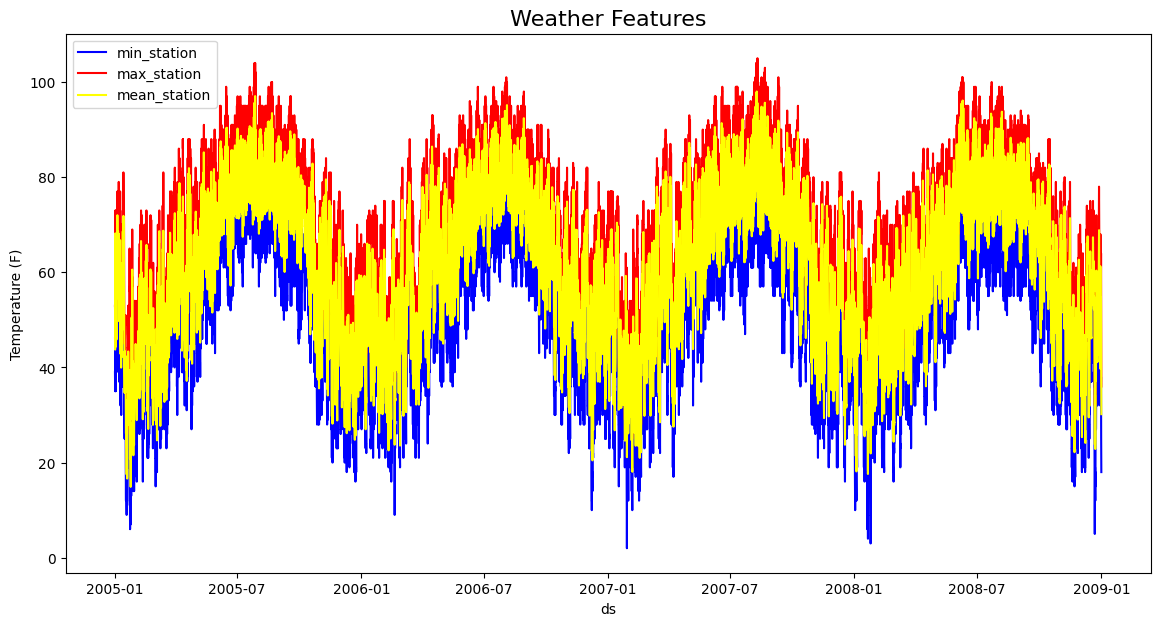

In [7]:
weather_features = weather.groupby(['ds']).agg(
    min_station_temp = ('temperature', np.min),
    max_station_temp = ('temperature', np.max),
    mean_station_temp = ('temperature', np.mean)
).reset_index()

g=sns.lineplot(data=weather_features, x='ds', y='min_station_temp', color='blue', label='min_station')
sns.lineplot(data=weather_features, x='ds', y='max_station_temp', color='red', label='max_station')
sns.lineplot(data=weather_features, x='ds', y='mean_station_temp', color='yellow', label='mean_station')
g.set_ylabel('Temperature (F)')
g.set_title('Weather Features', fontsize=16)

In [8]:
print(f"weather: {weather.ds.min().strftime('%Y-%m-%d')} - {weather.ds.max().strftime('%Y-%m-%d')}")
print(f"load: {load.index.min().strftime('%Y-%m-%d')} - {load.index.max().strftime('%Y-%m-%d')}")

weather: 2005-01-01 - 2008-12-31
load: 2005-01-01 - 2007-12-31


ds                   False
min_station_temp     False
max_station_temp     False
mean_station_temp    False
dtype: bool

I will assume that we can use **actual** weather data from 2008 to predict load data from 2008.  
Normally, we would have to use a weather **forecast** for 2008 as to predict load from 2008.

Alternatives would be to use average yearly temperatures as exogenous data.

In [9]:
from prophet import Prophet

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [125]:
mod_data = load.reset_index().rename(columns={'Load': 'y'})
mod_data['dow'] = mod_data.ds.dt.dayofweek
mod_data = pd.get_dummies(mod_data, prefix='dow', prefix_sep='_', columns=['dow'])
mod_data = mod_data.merge(weather_features, on='ds', how='left')
mod_data.head()


ds    y  dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  \
0 2005-01-01 00:00:00  857  False  False  False  False  False   True  False   
1 2005-01-01 01:00:00  825  False  False  False  False  False   True  False   
2 2005-01-01 02:00:00  800  False  False  False  False  False   True  False   
3 2005-01-01 03:00:00  794  False  False  False  False  False   True  False   
4 2005-01-01 04:00:00  802  False  False  False  False  False   True  False   

   min_station_temp  max_station_temp  mean_station_temp  
0                39                53          46.107143  
1                38                53          45.964286  
2                37                52          44.964286  
3                37                52          45.178571  
4                37                51          44.714286

In [130]:
future_df[future_df.max_station_temp.isna()]

ds  dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  \
27910 2008-03-09 01:00:00  False  False  False  False  False  False   True   

       min_station_temp  max_station_temp  mean_station_temp  
27910               NaN               NaN                NaN

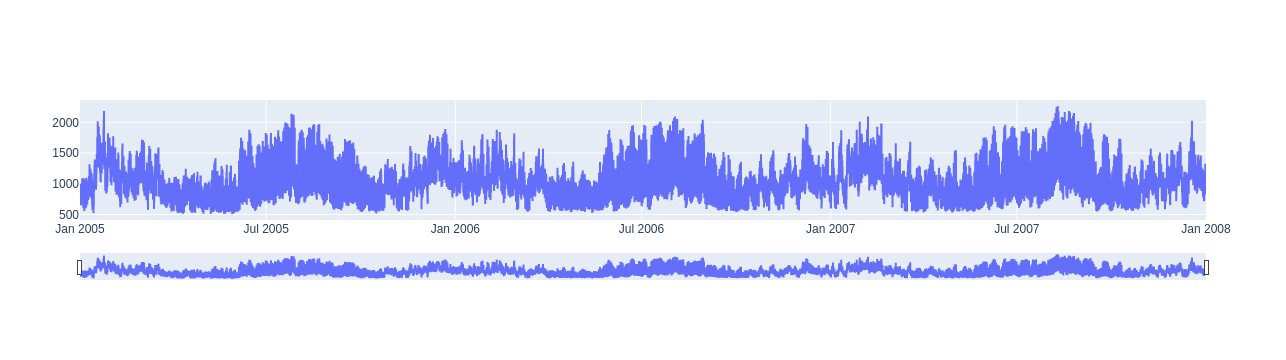

In [35]:
slider_plot(data=mod_data, x='ds', y='y')

In [107]:
mod_data

ds     y  dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  \
0     2005-01-01 00:00:00   857  False  False  False  False  False   True   
1     2005-01-01 01:00:00   825  False  False  False  False  False   True   
2     2005-01-01 02:00:00   800  False  False  False  False  False   True   
3     2005-01-01 03:00:00   794  False  False  False  False  False   True   
4     2005-01-01 04:00:00   802  False  False  False  False  False   True   
...                   ...   ...    ...    ...    ...    ...    ...    ...   
26272 2007-12-31 19:00:00  1269   True  False  False  False  False  False   
26273 2007-12-31 20:00:00  1255   True  False  False  False  False  False   
26274 2007-12-31 21:00:00  1237   True  False  False  False  False  False   
26275 2007-12-31 22:00:00  1212   True  False  False  False  False  False   
26276 2007-12-31 23:00:00  1174   True  False  False  False  False  False   

       dow_6  min_station_temp  max_station_temp  mean_station_temp  
0      False                39                53          46.107143  
1      False                38                53          45.964286  
2      False                37                52          44.964286  
3      False                37                52          45.178571  
4      False                37                51          44.714286  
...      ...               ...               ...                ...  
26272  False                37                50          42.678571  
26273  False                30                48          41.785714  
26274  False                34                49          41.107143  
26275  False                32                49          40.571429  
26276  False                32                48          40.607143  

[26277 rows x 12 columns]

ds     y  dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  \
0     2005-01-01 00:00:00   857  False  False  False  False  False   True   
1     2005-01-01 01:00:00   825  False  False  False  False  False   True   
2     2005-01-01 02:00:00   800  False  False  False  False  False   True   
3     2005-01-01 03:00:00   794  False  False  False  False  False   True   
4     2005-01-01 04:00:00   802  False  False  False  False  False   True   
...                   ...   ...    ...    ...    ...    ...    ...    ...   
26272 2007-12-31 19:00:00  1269   True  False  False  False  False  False   
26273 2007-12-31 20:00:00  1255   True  False  False  False  False  False   
26274 2007-12-31 21:00:00  1237   True  False  False  False  False  False   
26275 2007-12-31 22:00:00  1212   True  False  False  False  False  False   
26276 2007-12-31 23:00:00  1174   True  False  False  False  False  False   

       dow_6  min_station_temp  max_station_temp  mean_station_temp  
0      False                39                53          46.107143  
1      False                38                53          45.964286  
2      False                37                52          44.964286  
3      False                37                52          45.178571  
4      False                37                51          44.714286  
...      ...               ...               ...                ...  
26272  False                37                50          42.678571  
26273  False                30                48          41.785714  
26274  False                34                49          41.107143  
26275  False                32                49          40.571429  
26276  False                32                48          40.607143  

[26277 rows x 12 columns]

17:51:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 1 |███████████▍                                             | 00:01 Status

chain 3 |███████████▍                                             | 00:01 Status
chain 2 |███████████▍                                             | 00:01 Status


chain 4 |███████████▍                                             | 00:01 Status
chain 2 |██████████▍               | 25:29 Iteration:   1 / 300 [  0%]  (Warmup)


chain 4 |██████████▍               | 26:52 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████████▍               | 28:54 Iteration:   1 / 300 [  0%]  (Warmup)
chain 2 |███████████████▌          | 42:34 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |███████████████▌          | 46:19 

ds  dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  \
35056 2008-12-31 19:00:00  False  False   True  False  False  False  False   
35057 2008-12-31 20:00:00  False  False   True  False  False  False  False   
35058 2008-12-31 21:00:00  False  False   True  False  False  False  False   
35059 2008-12-31 22:00:00  False  False   True  False  False  False  False   
35060 2008-12-31 23:00:00  False  False   True  False  False  False  False   

       min_station_temp  max_station_temp  mean_station_temp  
35056              21.0              43.0          36.642857  
35057              19.0              41.0          34.750000  
35058              19.0              39.0          33.464286  
35059              19.0              37.0          31.785714  
35060              18.0              36.0          30.178571

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

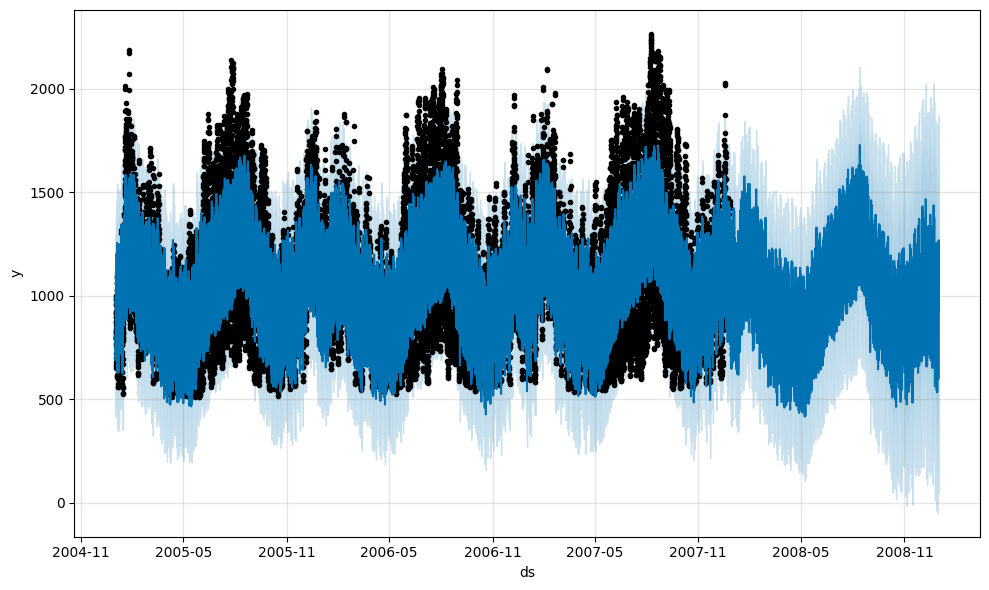

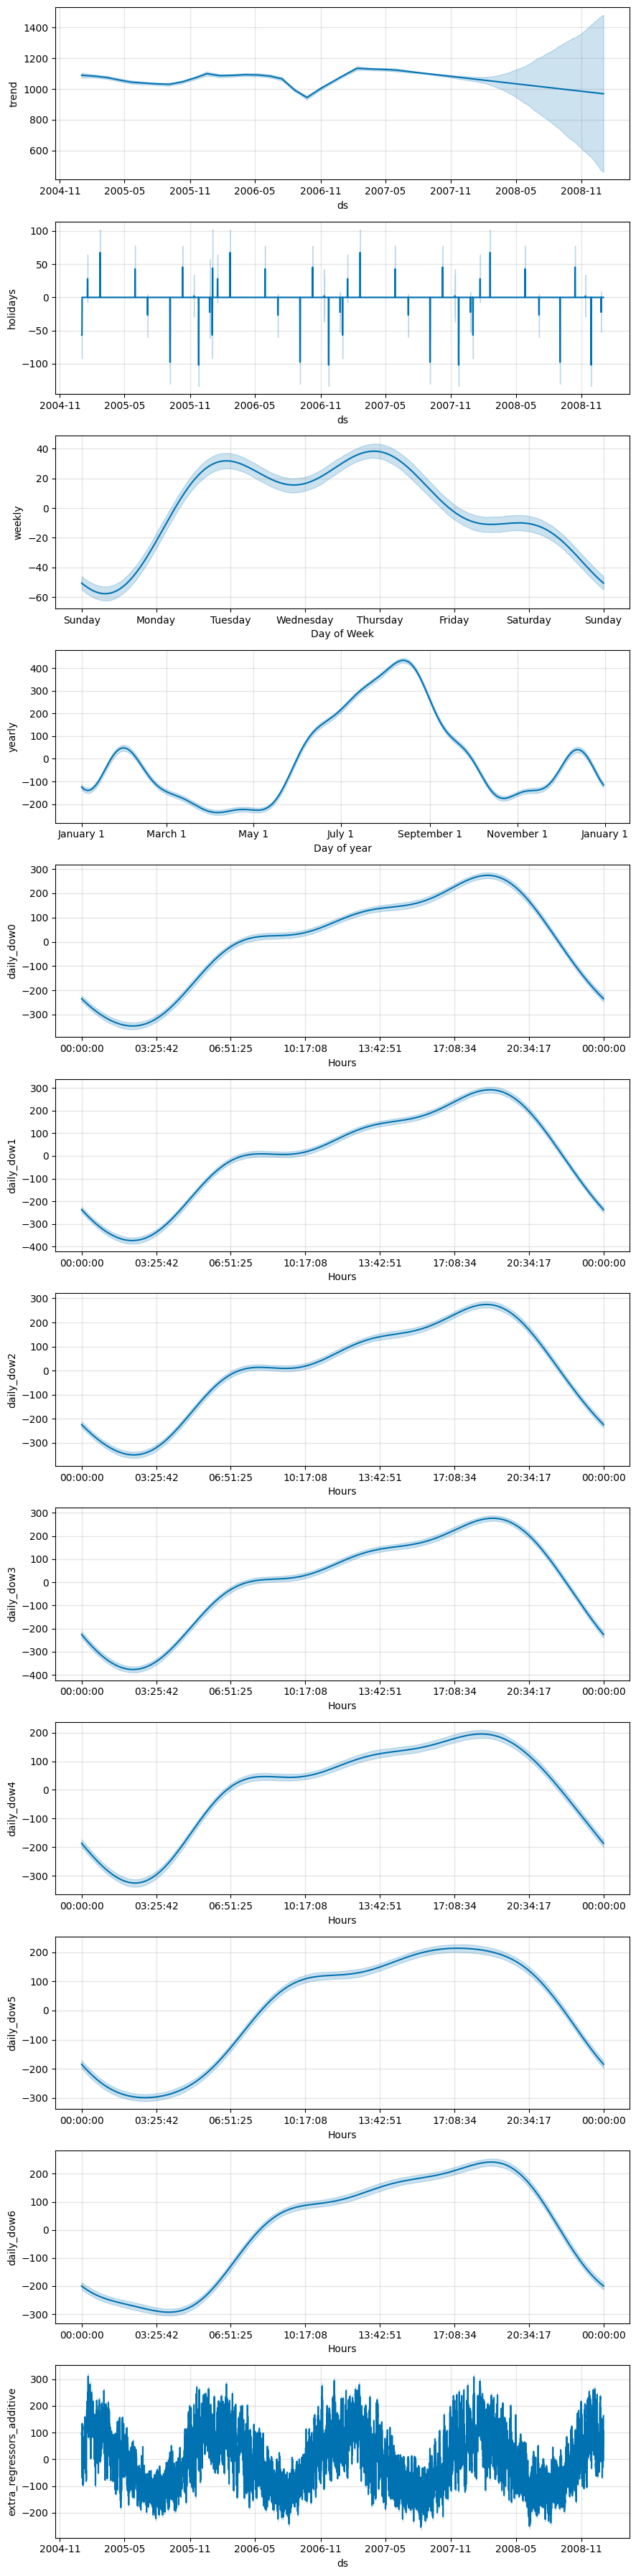

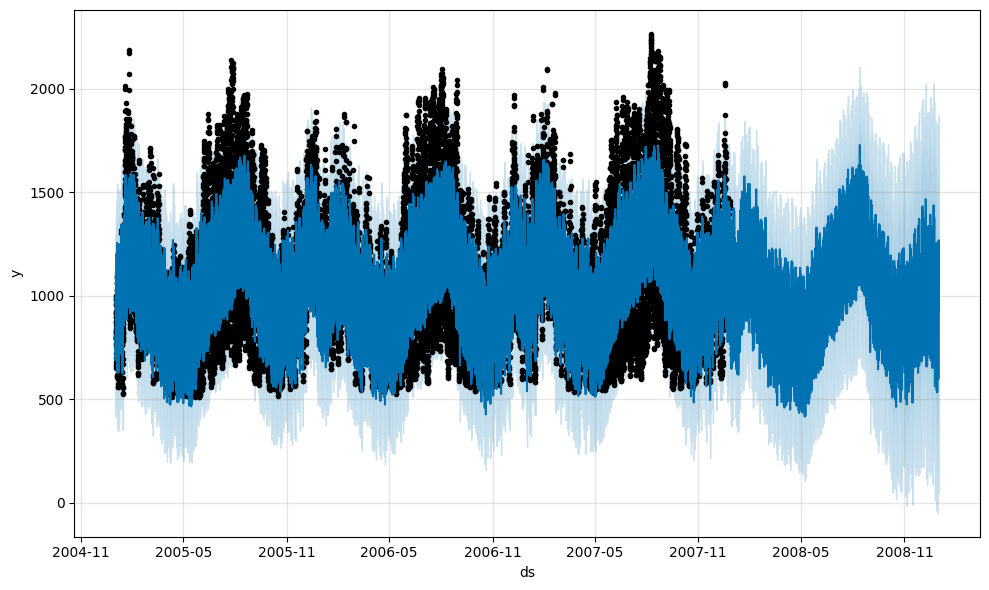

In [132]:
m = Prophet(daily_seasonality=False, mcmc_samples=300)
for i in range(7):
    m.add_seasonality(name=f"daily_dow{i}", period=1, fourier_order=4, condition_name=f"dow_{i}")

m.add_country_holidays(country_name='US')
m.add_regressor('max_station_temp')
m.add_regressor('min_station_temp')
m.add_regressor('mean_station_temp')
display(mod_data)
m.fit(mod_data)

future_df = m.make_future_dataframe(periods=(366)*24, freq='H')
future_df = future_df[future_df.ds < '2009-01-01']

future_df['dow'] = future_df.ds.dt.dayofweek
future_df = pd.get_dummies(future_df, prefix='dow', prefix_sep='_', columns=['dow'])
future_df = future_df.merge(weather_features, on='ds', how='left')
future_df['min_station_temp'].interpolate(inplace=True, method='linear')
future_df['max_station_temp'].interpolate(inplace=True, method='linear')
future_df['mean_station_temp'].interpolate(inplace=True, method='linear')


display(future_df.tail())

preds = m.predict(future_df)
fig = m.plot_components(preds)
m.plot(preds)

In [134]:
samps = m.predictive_samples(future_df)
samps['yhat']

array([[ 842.61245818,  683.05335016,  750.76819703, ...,  790.43181797,
         716.71735894, 1225.01513668],
       [ 650.19672818, 1055.22805525,  907.07351016, ...,  440.90362064,
         748.4184325 ,  656.25504744],
       [ 576.44778216,  317.7363317 ,  672.57283932, ...,  172.11542267,
         596.24334508,  622.77531897],
       ...,
       [ 980.55319133, 1689.55549238, 1131.444308  , ..., 1446.53400725,
         732.5219214 , 1872.70404751],
       [ 801.86437947, 1847.00795349, 1288.15832384, ...,  968.02693079,
        1324.94817894, 1544.06244351],
       [ 440.78731727, 1729.42001639,  976.44117984, ...,  527.58339511,
        1027.228884  , 1676.56335078]])

In [135]:
samps['yhat'].shape

(35061, 1200)

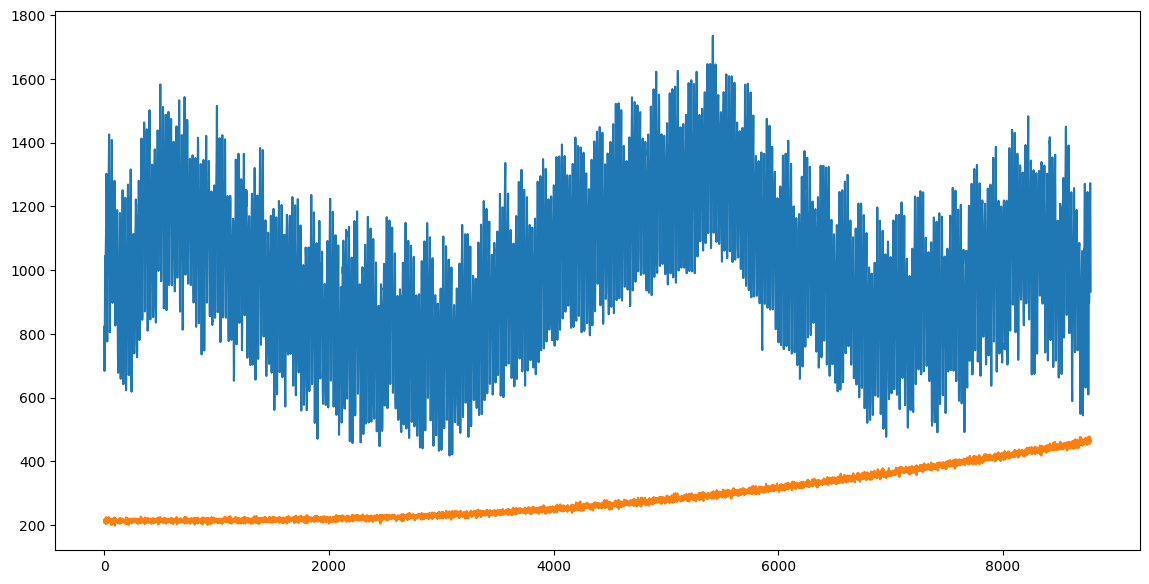

In [147]:
future_samps = samps['yhat'][list(future_df.index[future_df.ds >= '2008-01-01']), :]

plt.plot(future_samps.mean(axis=1))
plt.plot(future_samps.std(axis=1))

In [148]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open('./models/mod1.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model



In [55]:
import plotly.graph_objects as go


def slider_plot(data, x, y):
    ''' Create a plotly lineplot with range slider '''
    # Create figure
    fig = go.Figure()
    # Show line
    fig.add_trace(go.Scatter(x=list(data[x]), y=list(data[y])))
    # Add range slider
    fig.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="date"))
    
    fig.show()

    

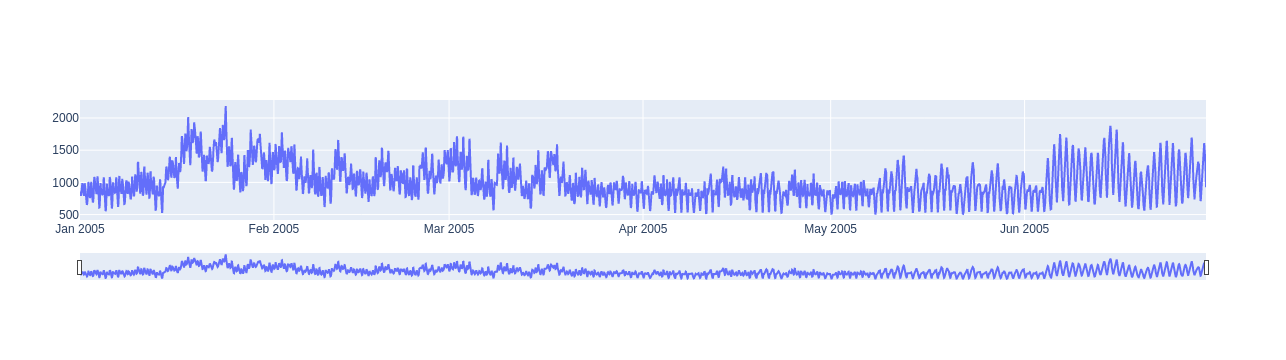

In [56]:
slider_plot(data=mod_data[mod_data.ds <= '2005-06-30'], x='ds', y='y')

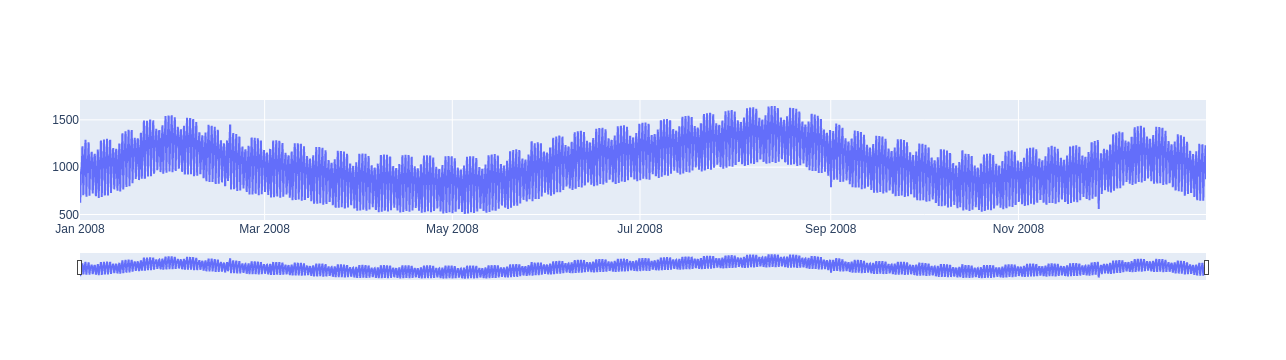

In [97]:
slider_plot(data=preds[preds.ds >= '2008-01-01'], x='ds', y='yhat')

In [50]:
from sktime.registry import all_tags, all_estimators

In [51]:
all_tags(estimator_types=['forecaster'], as_dataframe=True)

name  \
0       X-y-must-have-same-index   
1                  X_inner_mtype   
2            capability:insample   
3            capability:pred_int   
4   capability:pred_int:insample   
5            capability:pred_var   
6             enforce_index_type   
7           ignores-exogeneous-X   
8                  remember_data   
9             requires-fh-in-fit   
10                     scitype:y   
11                 y_inner_mtype   

                                              scitype  \
0                             [forecaster, regressor]   
1   [clusterer, forecaster, transformer, transform...   
2                                          forecaster   
3                                          forecaster   
4                                          forecaster   
5                                          forecaster   
6                             [forecaster, regressor]   
7                                          forecaster   
8                           [forecaster, transformer]   
9                                          forecaster   
10                                         forecaster   
11                          [forecaster, transformer]   

                                                 type  \
0                                                bool   
1   (list, [pd.Series, pd.DataFrame, np.array, nes...   
2                                                bool   
3                                                bool   
4                                                bool   
5                                                bool   
6                                                type   
7                                                bool   
8                                                bool   
9                                                bool   
10            (str, [univariate, multivariate, both])   
11  (list, [pd.Series, pd.DataFrame, np.array, nes...   

                                          description  
0   do X/y in fit/update and X/fh in predict have ...  
1   which machine type(s) is the internal _fit/_pr...  
2      can the forecaster make in-sample predictions?  
3   does the forecaster implement predict_interval...  
4   can the forecaster make in-sample predictions ...  
5     does the forecaster implement predict_variance?  
6   passed to input checks, input conversion index...  
7         does forecaster ignore exogeneous data (X)?  
8   whether estimator remembers all data seen as s...  
9   does forecaster require fh passed already in f...  
10  which series type does the forecaster support?...  
11  which machine type(s) is the internal _fit/_pr...

name                                             object
0  NaiveForecaster  <class 'sktime.forecasting.naive.NaiveForecast...
1    NaiveVariance   <class 'sktime.forecasting.naive.NaiveVariance'>